Basic imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import deque
from scipy import stats
import numpy as np
import random, math, pickle
random.seed(100)

In [2]:
# load dataset
authors_data = pickle.load(open("Dataset/author_index_all_month.p", "rb"))

In [3]:
authors_data[0]

{'articles': [{'c_ten': 8,
   'date': '1949-09-15',
   'id': '10.1103-PhysRev.76.854',
   'year': 1949},
  {'c_ten': 6,
   'date': '1953-10-15',
   'id': '10.1103-PhysRev.92.441',
   'year': 1953}],
 'c_ten_star': 8,
 'first_year': 1949,
 'id': 0,
 'in_core': False,
 'last_year': 1953,
 'surface': 'p.  bassi'}

In [4]:
# load list of authors used in the article
author_list_file = "SupplementaryDataSinatra2016/sinatra_Science_id_studied.dat"
valid_author_list = list()
with open(author_list_file) as f:
    for line in f.readlines():
        if len(line) > 0:
            valid_author_list.append(int(line))

In [5]:
print(len(authors_data)) # number of total authors
print(len(valid_author_list)) # number of authors used in the article

151714
2887


In [6]:
# filter
authors_data = {x:y for x,y in authors_data.items() if x in valid_author_list}

In [7]:
print(len(authors_data)) # 1 author is missing..

2886


In [8]:
print(np.sum([1 for a in authors_data.values() for x in a["articles"]])) # number of articles from selected authors

131596


plot 1E: average number of papers per class of authors (productivity)

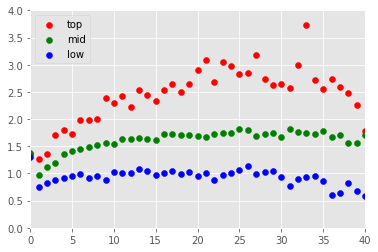

In [9]:
# TOP authors
n_auth = np.array([len([a for a in authors_data.values() if a["c_ten_star"] >= 200 and (a["last_year"]-a["first_year"] >= x)]) for x in range(41)])
productivity_top = np.zeros((1,41))
for a in authors_data.values():
    if a["c_ten_star"] >= 200:
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < productivity_top.shape[1]:
                productivity_top[0,slot] += 1
productivity_top = np.true_divide(productivity_top,n_auth)

# MID authors
n_auth = np.array([len([a for a in authors_data.values() if (a["c_ten_star"] > 20 and a["c_ten_star"] < 200) and (a["last_year"]-a["first_year"] >= x)]) for x in range(41)])
productivity_mid = np.zeros((1,41))
for a in authors_data.values():
    if (a["c_ten_star"] > 20 and a["c_ten_star"] < 200):
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < productivity_mid.shape[1]:
                productivity_mid[0,slot] += 1
productivity_mid = np.true_divide(productivity_mid,n_auth)

# LOW authors
n_auth = np.array([len([a for a in authors_data.values() if a["c_ten_star"] <= 20 and (a["last_year"]-a["first_year"] >= x)]) for x in range(41)])
productivity_low = np.zeros((1,41))
for a in authors_data.values():
    if a["c_ten_star"] <= 20:
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < productivity_low.shape[1]:
                productivity_low[0,slot] += 1
productivity_low = np.true_divide(productivity_low,n_auth)

# plots
plt.scatter(range(41),productivity_top,c="red",label="top")
plt.scatter(range(41),productivity_mid,c="green",label="mid")
plt.scatter(range(41),productivity_low,c="blue",label="low")
plt.xlim((0,40))
plt.ylim((0,4))
plt.legend(loc='upper left')

plot 2B: c_ten_star and neighbouring publications

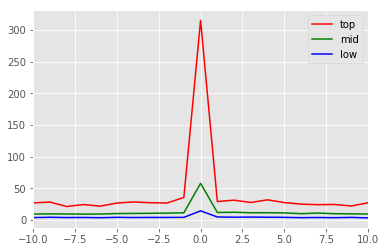

In [10]:
window = 10 # how many publications to take before and after max
impact_array_top = np.zeros((1,1+(window*2)))
n_pub_array_top = np.zeros((1,1+(window*2)))
impact_array_mid = np.zeros((1,1+(window*2)))
n_pub_array_mid = np.zeros((1,1+(window*2)))
impact_array_low = np.zeros((1,1+(window*2)))
n_pub_array_low = np.zeros((1,1+(window*2)))
for a in authors_data.values():
    cits = [x["c_ten"] for x in a["articles"]]
    m = np.argmax(cits)
    if a["c_ten_star"] >= 200: #top authors
        impact_array_top[0,window] += cits[m]
        n_pub_array_top[0,window] += 1
        for n in range(1,window+1):
            # before
            if m-n >= 0:
                impact_array_top[0,window-n] += cits[m-n]
                n_pub_array_top[0,window-n] += 1
            # after
            if m+n < len(cits):
                impact_array_top[0,window+n] += cits[m+n]
                n_pub_array_top[0,window+n] += 1
    elif a["c_ten_star"] <= 20: #low authors
        impact_array_low[0,window] += cits[m]
        n_pub_array_low[0,window] += 1
        for n in range(1,window+1):
            # before
            if m-n >= 0:
                impact_array_low[0,window-n] += cits[m-n]
                n_pub_array_low[0,window-n] += 1
            # after
            if m+n < len(cits):
                impact_array_low[0,window+n] += cits[m+n]
                n_pub_array_low[0,window+n] += 1
    else: #mid authors
        impact_array_mid[0,window] += cits[m]
        n_pub_array_mid[0,window] += 1
        for n in range(1,window+1):
            # before
            if m-n >= 0:
                impact_array_mid[0,window-n] += cits[m-n]
                n_pub_array_mid[0,window-n] += 1
            # after
            if m+n < len(cits):
                impact_array_mid[0,window+n] += cits[m+n]
                n_pub_array_mid[0,window+n] += 1
impact_array_top = np.true_divide(impact_array_top,n_pub_array_top)
impact_array_mid = np.true_divide(impact_array_mid,n_pub_array_mid)
impact_array_low = np.true_divide(impact_array_low,n_pub_array_low)

# plots
plt.plot(range(-window,window+1),impact_array_top[0,:],c="red",label="top")
plt.plot(range(-window,window+1),impact_array_mid[0,:],c="green",label="mid")
plt.plot(range(-window,window+1),impact_array_low[0,:],c="blue",label="low")
plt.xlim(-window,window)
plt.legend(loc="best")

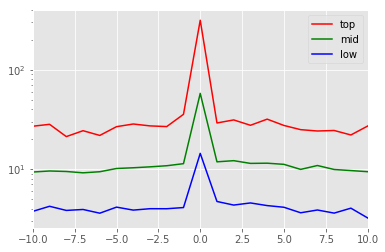

In [11]:
# log rescale of the same plot
plt.plot(range(-window,window+1),impact_array_top[0,:],c="red",label="top")
plt.plot(range(-window,window+1),impact_array_mid[0,:],c="green",label="mid")
plt.plot(range(-window,window+1),impact_array_low[0,:],c="blue",label="low")
plt.legend(loc="best")
plt.xlim(-window,window)
plt.yscale('log')
plt.legend(loc="best")

Plot 2A: average impact of papers
Using the global average of the average c_ten per researcher per year

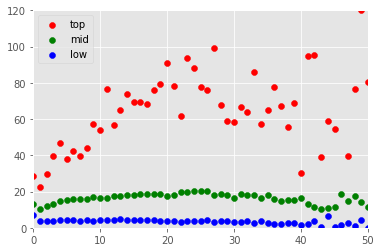

In [12]:
window = 50
# TOP authors
n_auth = np.array([len([a for a in authors_data.values() if a["c_ten_star"] >= 200 and (a["last_year"]-a["first_year"] >= x)]) for x in range(window+1)])
c_ten_top = np.zeros((1,window+1))
for a in authors_data.values():
    if a["c_ten_star"] >= 200:
        c_ten_local = np.zeros((1,window+1))
        n_art_local = np.zeros((1,window+1))
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < c_ten_top.shape[1]:
                c_ten_local[0,slot] += article["c_ten"]
                n_art_local[0,slot] += 1
        c_ten_top = np.add(c_ten_top,c_ten_local)
c_ten_top = np.true_divide(c_ten_top,n_auth)
# MID authors
n_auth = np.array([len([a for a in authors_data.values() if (a["c_ten_star"] > 20 and a["c_ten_star"] < 200) and (a["last_year"]-a["first_year"] >= x)]) for x in range(window+1)])
c_ten_mid = np.zeros((1,window+1))
for a in authors_data.values():
    if (a["c_ten_star"] > 20 and a["c_ten_star"] < 200):
        c_ten_local = np.zeros((1,window+1))
        n_art_local = np.zeros((1,window+1))
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < c_ten_mid.shape[1]:
                c_ten_local[0,slot] += article["c_ten"]
                n_art_local[0,slot] += 1
        c_ten_mid = np.add(c_ten_mid,c_ten_local)
c_ten_mid = np.true_divide(c_ten_mid,n_auth)
# LOW authors
n_auth = np.array([len([a for a in authors_data.values() if a["c_ten_star"] <= 20 and (a["last_year"]-a["first_year"] >= x)]) for x in range(window+1)])
c_ten_low = np.zeros((1,window+1))
for a in authors_data.values():
    if a["c_ten_star"] <= 20:
        c_ten_local = np.zeros((1,window+1))
        n_art_local = np.zeros((1,window+1))
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < c_ten_low.shape[1]:
                c_ten_local[0,slot] += article["c_ten"]
                n_art_local[0,slot] += 1
        c_ten_low = np.add(c_ten_low,c_ten_local)
c_ten_low = np.true_divide(c_ten_low,n_auth)

# plot
plt.scatter(range(window+1),c_ten_top,c="red",label="top")
plt.scatter(range(window+1),c_ten_mid,c="green",label="mid")
plt.scatter(range(window+1),c_ten_low,c="blue",label="low")
plt.xlim((0,window))
plt.ylim((0,120))
plt.legend(loc='upper left')

Plot 2A: average impact of papers
Using the global average of the average c_ten per researcher per year, with confidence intervals

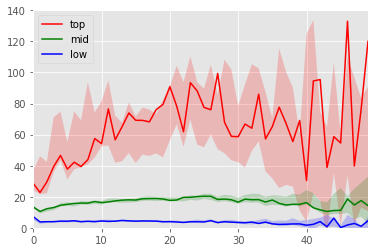

In [13]:
window = 50
# TOP authors
n_auth = np.array([len([a for a in authors_data.values() if a["c_ten_star"] >= 200 and (a["last_year"]-a["first_year"] >= x)]) for x in range(window)])
c_ten_top = np.zeros((1,window))
c_ten_top_random = {n:list() for n in range(window)}
for a in authors_data.values():
    if a["c_ten_star"] >= 200:
        random_c_ten_local = np.zeros((1,window))
        c_ten_local = np.zeros((1,window))
        n_art_local = np.zeros((1,window))
        c_tens = [x["c_ten"] for x in a["articles"]]
        random.shuffle(c_tens)
        c_tens = deque(c_tens)
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < c_ten_top.shape[1]:
                c_ten_local[0,slot] += article["c_ten"]
                random_c_ten_local[0,slot] += c_tens.pop()
                n_art_local[0,slot] += 1
        c_ten_top = np.add(c_ten_top,c_ten_local)
        for n in range(random_c_ten_local.shape[1]):
            if n <= a["last_year"]-a["first_year"]:
                c_ten_top_random[n].append(random_c_ten_local[0,n])
c_ten_top = np.true_divide(c_ten_top,n_auth)
# MID authors
n_auth = np.array([len([a for a in authors_data.values() if (a["c_ten_star"] > 20 and a["c_ten_star"] < 200) and (a["last_year"]-a["first_year"] >= x)]) for x in range(window)])
c_ten_mid = np.zeros((1,window))
c_ten_mid_random = {n:list() for n in range(window)}
for a in authors_data.values():
    if (a["c_ten_star"] > 20 and a["c_ten_star"] < 200):
        random_c_ten_local = np.zeros((1,window))
        c_ten_local = np.zeros((1,window))
        n_art_local = np.zeros((1,window))
        c_tens = [x["c_ten"] for x in a["articles"]]
        random.shuffle(c_tens)
        c_tens = deque(c_tens)
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < c_ten_mid.shape[1]:
                c_ten_local[0,slot] += article["c_ten"]
                random_c_ten_local[0,slot] += c_tens.pop()
                n_art_local[0,slot] += 1
        c_ten_mid = np.add(c_ten_mid,c_ten_local)
        for n in range(random_c_ten_local.shape[1]):
            if n <= a["last_year"]-a["first_year"]:
                c_ten_mid_random[n].append(random_c_ten_local[0,n])
c_ten_mid = np.true_divide(c_ten_mid,n_auth)
# LOW authors
n_auth = np.array([len([a for a in authors_data.values() if a["c_ten_star"] <= 20 and (a["last_year"]-a["first_year"] >= x)]) for x in range(window)])
c_ten_low = np.zeros((1,window))
c_ten_low_random = {n:list() for n in range(window)}
for a in authors_data.values():
    if a["c_ten_star"] <= 20:
        random_c_ten_local = np.zeros((1,window))
        c_ten_local = np.zeros((1,window))
        n_art_local = np.zeros((1,window))
        c_tens = [x["c_ten"] for x in a["articles"]]
        random.shuffle(c_tens)
        c_tens = deque(c_tens)
        for article in a["articles"]:
            slot = article["year"] - a["first_year"]
            if slot < c_ten_low.shape[1]:
                c_ten_local[0,slot] += article["c_ten"]
                random_c_ten_local[0,slot] += c_tens.pop()
                n_art_local[0,slot] += 1
        c_ten_low = np.add(c_ten_low,c_ten_local)
        for n in range(random_c_ten_local.shape[1]):
            if n <= a["last_year"]-a["first_year"]:
                c_ten_low_random[n].append(random_c_ten_local[0,n])
c_ten_low = np.true_divide(c_ten_low,n_auth)

# plot
# confidence intervals for the mean
z_critical = stats.norm.ppf(q = 0.975) # 95% confidence interval
lower_bound = [np.mean(x) - (z_critical*(np.std(x)/math.sqrt(len(x)))) for x in c_ten_top_random.values()]
upper_bound = [np.mean(x) + (z_critical*(np.std(x)/math.sqrt(len(x)))) for x in c_ten_top_random.values()]
plt.fill_between(range(window), lower_bound, upper_bound, facecolor='red', alpha=0.2)
lower_bound = [np.mean(x) - (z_critical*(np.std(x)/math.sqrt(len(x)))) for x in c_ten_mid_random.values()]
upper_bound = [np.mean(x) + (z_critical*(np.std(x)/math.sqrt(len(x)))) for x in c_ten_mid_random.values()]
plt.fill_between(range(window), lower_bound, upper_bound, facecolor='green', alpha=0.2)
lower_bound = [np.mean(x) - (z_critical*(np.std(x)/math.sqrt(len(x)))) for x in c_ten_low_random.values()]
upper_bound = [np.mean(x) + (z_critical*(np.std(x)/math.sqrt(len(x)))) for x in c_ten_low_random.values()]
plt.fill_between(range(window), lower_bound, upper_bound, facecolor='blue', alpha=0.2)

plt.plot(range(window),np.ravel(c_ten_top),c="red",label="top")
plt.plot(range(window),np.ravel(c_ten_mid),c="green",label="mid")
plt.plot(range(window),np.ravel(c_ten_low),c="blue",label="low")
plt.xlim((0,window-1))
plt.ylim((0,140))
plt.legend(loc='upper left')